In [ ]:
# must install comet ml before any other ml libraries
%pip install comet-ml

In [ ]:
# initialize comet by adding project name and api key
import comet_ml
comet_ml.init(project_name='huggingface')

In [ ]:
%pip install torch numpy scikit-learn transformers datasets transformers[torch] huggingface_hub

In [49]:
from transformers import TrainingArguments, AutoTokenizer, \
                         AutoModelForSequenceClassification
import matplotlib.pyplot as plt

# defines and returns parameters used throughout
def get_parameters():

    columns_to_remove = [
        'author',
        'subreddit',
        'link_id',
        'parent_id',
        'created_utc',
        'rater_id',
        'example_very_unclear',
        'admiration',
        'approval',
        'caring',
        'confusion',
        'desire',
        'disappointment',
        'disapproval',
        'excitement',
        'nervousness',
        'pride',
        'realization',
        'relief',
        'remorse',
        'surprise'
    ]

    emotions = [
        'amusement',
        'anger',
        'annoyance',
        'curiosity',
        'disgust',
        'embarrassment',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'optimism',
        'sadness',
        'neutral'
    ]

    training_args = TrainingArguments(
        output_dir='./model_output',
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        save_total_limit=3,
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
         greater_is_better=True,
        report_to='comet_ml'
   )

    id2label = {idx:label for idx, label in enumerate(emotions)}
    label2id = {label:idx for idx, label in enumerate(emotions)}

    settings = {
        'columns_to_remove': columns_to_remove,
        'emotions': emotions,
        'training_args': training_args,
        'num_labels': len(emotions),
        'tokenizer': AutoTokenizer.from_pretrained("roberta-base"),
        'model': AutoModelForSequenceClassification.from_pretrained("roberta-base",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(emotions),
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           ignore_mismatched_sizes=True)
    }

    return settings

# maps predicted probabilities to emotion classes
def map_probs_to_emotions(probs, emotions):
    emotion_probabilities = []

    for prob in probs:
        emotion_probs = {emotion: p for emotion, p in zip(emotions, prob)}
        emotion_probabilities.append(emotion_probs)

    return emotion_probabilities

# creates plot to visualize predicitons on test data
def visualize_emotion_probabilities(predictions, texts, true_labels):
    num_texts = len(predictions)
    num_cols = 2
    num_rows = (num_texts + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for idx, (emotion_probs, text, true_lbls) in enumerate(zip(predictions, texts, true_labels)):
        ax = axes[idx // num_cols * num_cols + idx % num_cols]
        emotions = list(emotion_probs.keys())
        probs = list(emotion_probs.values())

        ax.bar(emotions, probs, color='skyblue')
        ax.set_ylabel('Probability')
        ax.set_title(f'Text Input: {text}\nTrue Label(s): {true_lbls}')
        ax.set_xticklabels(emotions, rotation=45, ha='right')

    if num_texts % num_cols != 0:
        axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

In [50]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
from transformers import EvalPrediction
import torch

settings = get_parameters()

# computes metrics to evaluate model performance
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, probs, average='micro')
    subset_accuracy = accuracy_score(y_true, y_pred, normalize=False) / y_true.shape[0]
    hammingloss = hamming_loss(y_true, y_pred)

    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'subset_accuracy': subset_accuracy,
        'hamming_loss': hammingloss
    }

    return metrics

# controls metrics to run
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)

    return result

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
import numpy as np

class Preprocess:
    def __init__(self):
        self.settings = get_parameters()
        self.tokenizer = self.settings['tokenizer']

    # tokenizes and formats data into format accepted by model
    def tokenize_data(self, batch):
        text = batch['text']
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=128)
        labels_batch = {k: batch[k] for k in batch.keys() if k in self.settings['emotions']}
        labels_matrix = np.zeros((len(text), self.settings['num_labels']))

        for idx, label in enumerate(self.settings['emotions']):
            labels_matrix[:, idx] = labels_batch[label]

        encoding['labels'] = labels_matrix.tolist()

        return encoding

In [52]:
from transformers import TrainerCallback

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience: int):
        self.early_stopping_patience = early_stopping_patience
        self.best_metric = None
        self.patience_counter = 0

    # checks to see if metrics have stabilized
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        current_metric = metrics.get('eval_f1', None)
        if self.best_metric is None or current_metric > self.best_metric:
            self.best_metric = current_metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print('Early stopping triggered!')
                control.should_training_stop = True
                control.should_evaluate = False
                control.should_save = True

In [54]:
from transformers import Trainer
from transformers.integrations import CometCallback
from datasets import load_dataset, DatasetDict

# initialize objects
settings = get_parameters()
preprocess = Preprocess()

# load dataset & preprocess data
print("\nLoading & preprocessing dataset...")
dataset = load_dataset('go_emotions', name='raw', split='train')
# split the dataset
train_test = dataset.train_test_split(test_size=0.2)
test_validation = train_test['test'].train_test_split(test_size=0.5)
go_emotions = DatasetDict({
    'train': train_test['train'],
    'test': test_validation['test'],
    'validation': test_validation['train']
})

# remove columns containing non-target emotions & instances containing no positive target emotions
print("\nRemoving non-target emotion columns & instances containing no positive classifications...")
go_emotions = go_emotions.remove_columns(settings['columns_to_remove'])
go_emotions = go_emotions.filter(lambda row: any(row[emotion] == 1 for emotion in settings['emotions']))

# tokenize text for input into model & set format
print("\nTokenizing dataset...")
test_texts = go_emotions['test']['text']
tokenized_dataset = go_emotions.map(preprocess.tokenize_data, batched=True, remove_columns=go_emotions['train'].column_names)
tokenized_dataset.set_format("torch")

print("Data Preprocessing Complete.")

# define early stopping object to stop training early
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# define trainer
trainer = Trainer(
  model=settings['model'],
  args=settings['training_args'],
  train_dataset=tokenized_dataset['train'],
  eval_dataset=tokenized_dataset['validation'],
  tokenizer=settings['tokenizer'],
  compute_metrics=compute_metrics,
  callbacks=[CometCallback(), early_stopping_callback]
)

# train and evaluate model
print("\nTraining model...")
train_result = trainer.train()
print(f"Training completed.\nResults: {train_result}")

print("\nEvaluating model on validation dataset...")
eval_result = trainer.evaluate()
print(f"Validation evaluation completed.\nResults: {eval_result}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading & preprocessing dataset...

Removing non-target emotion columns & instances containing no positive classifications...


Filter:   0%|          | 0/168980 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21122 [00:00<?, ? examples/s]


Tokenizing dataset...


Map:   0%|          | 0/112506 [00:00<?, ? examples/s]

Map:   0%|          | 0/14057 [00:00<?, ? examples/s]

Map:   0%|          | 0/14176 [00:00<?, ? examples/s]

You are adding a <class 'transformers.integrations.integration_utils.CometCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
CometCallback


Data Preprocessing Complete.

Training model...


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mkschulz9/huggingface/f2ab0783686347b5a7bcb0ed758f9b2c

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mkschulz9/huggingface/f2ab0783686347b5a7bcb0ed758f9b2c
COMET INFO:   Parameters:
COMET INFO:     args/_n_gpu                             : 1
COMET INFO:     args/_no_sync_in_gradient_accumulat

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Subset Accuracy,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.150700,0.148533,0.575326,0.930612,0.495415,0.056318,96.329600,147.161000,18.395000
2,0.145100,0.142490,0.572860,0.938597,0.476439,0.055400,96.418500,147.026000,18.378000
3,0.130600,0.145176,0.590313,0.937348,0.507125,0.055531,96.317500,147.180000,18.397000
4,0.127100,0.146694,0.583336,0.936691,0.494850,0.056217,96.491100,146.915000,18.364000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Subset Accuracy,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.150700,0.148533,0.575326,0.930612,0.495415,0.056318,96.329600,147.161000,18.395000
2,0.145100,0.142490,0.572860,0.938597,0.476439,0.055400,96.418500,147.026000,18.378000
3,0.130600,0.145176,0.590313,0.937348,0.507125,0.055531,96.317500,147.180000,18.397000
4,0.127100,0.146694,0.583336,0.936691,0.494850,0.056217,96.491100,146.915000,18.364000
5,0.117200,0.152763,0.583072,0.933535,0.502751,0.057532,96.385100,147.077000,18.385000


COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mkschulz9/huggingface/f63585e3ad2f4b2780fab7f747a66820
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [292]                  : (0.04, 5.0)
COMET INFO:     eval_f1 [10]                 : (0.5728604172332078, 0.5903126277833537)
COMET INFO:     eval_hamming_loss [10]       : (0.055400475653015153, 0.05753184456626895)
COMET INFO:     eval_loss [10]               : (0.14248977601528168, 0.15276303887367249)
COMET INFO:     eval_roc_auc [10]            : (0.9306120533380983, 0.9385967411843075)
COMET INFO:     eval_runtime [10]            : (96.3175, 96.

Training completed.
Results: TrainOutput(global_step=70320, training_loss=0.1399313408088901, metrics={'train_runtime': 14940.2328, 'train_samples_per_second': 37.652, 'train_steps_per_second': 4.707, 'total_flos': 3.700595220152832e+16, 'train_loss': 0.1399313408088901, 'epoch': 5.0})

Evaluating model on validation dataset...


Early stopping triggered!
Validation evaluation completed.
Results: {'eval_loss': 0.14517611265182495, 'eval_f1': 0.5903126277833537, 'eval_roc_auc': 0.9373483193840275, 'eval_subset_accuracy': 0.5071247178329571, 'eval_hamming_loss': 0.055531481780070946, 'eval_runtime': 96.6887, 'eval_samples_per_second': 146.615, 'eval_steps_per_second': 18.327, 'epoch': 5.0}



Evaluating model on test dataset...


Test evaluation completed.
Results: {'test_loss': 0.14464735984802246, 'test_f1': 0.5959340700788293, 'test_roc_auc': 0.9370197439632095, 'test_subset_accuracy': 0.5088567973251761, 'test_hamming_loss': 0.05443652882651247, 'test_runtime': 97.1279, 'test_samples_per_second': 144.727, 'test_steps_per_second': 18.1}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-27824535d4d4>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotions, rotation=45, ha='right')


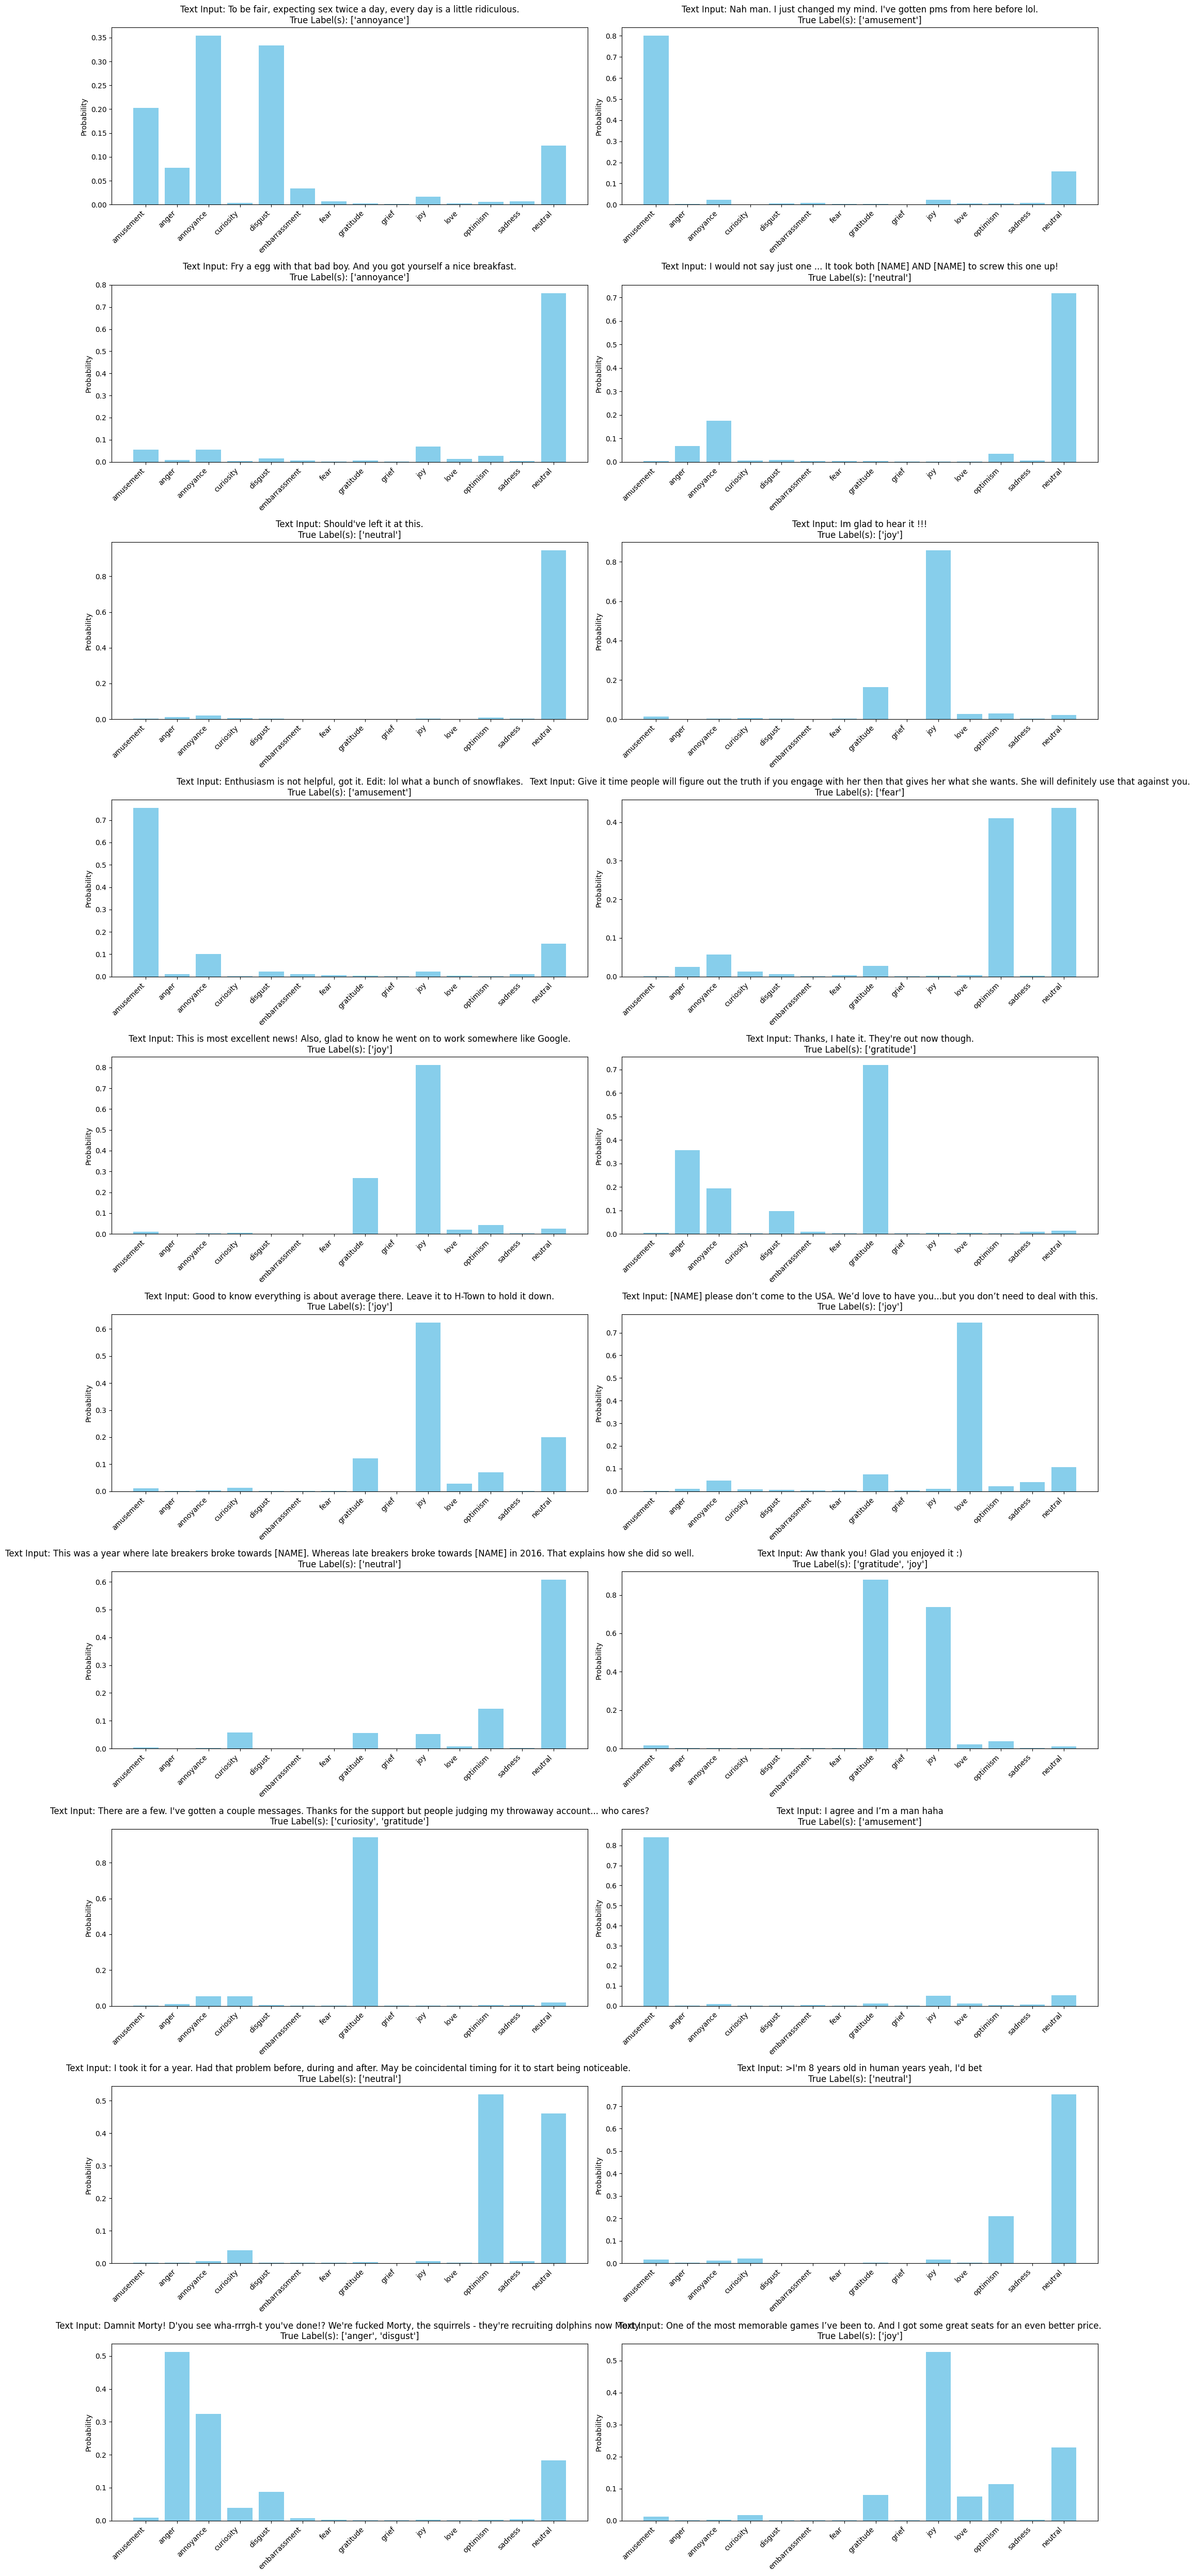

In [55]:
# evaluate test dataset on model (after training is completely finished)
print("\nEvaluating model on test dataset...")
test_results = trainer.predict(test_dataset=tokenized_dataset['test'])
print(f"Test evaluation completed.\nResults: {test_results.metrics}\n")

# apply sigmoid to the logits to get probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(test_results.predictions))
probs = probs.numpy()

# map probabilities to emotion classes
emotions = get_parameters()['emotions']
emotion_probabilities = map_probs_to_emotions(probs, emotions)

# Visualize the predictions for the first instances
# Extract the true labels from the test dataset
true_labels = tokenized_dataset['test']['labels']

# Convert the list of lists of label indices to lists of label names
true_labels_names = []
for label_row in true_labels:
    label_names = [emotions[idx] for idx, label in enumerate(label_row) if label == 1]
    true_labels_names.append(label_names)

# Truncate the lists to match the number of predictions you want to visualize
num_to_visualize = 20
visualize_emotion_probabilities(emotion_probabilities[:num_to_visualize],
                                test_texts[:num_to_visualize],
                                true_labels_names[:num_to_visualize])